In [2]:
%matplotlib inline

In [5]:
import data_processor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

## Load data

In [12]:
df_2018 = data_processor.load_dataframe('data/data2018.mat')
df_2018['shoe'] = df_2018.label == 'shoe'
df_2018

,gx,gy,gz,std,skewness,f25,f75,label,shoe
0,-1.544601,-3.817323,8.094007,2.908658,0.610852,2.145741,2.671228,brushing,False
1,1.564355,6.303785,6.155559,4.249809,0.935402,3.468531,7.794872,brushing,False
2,2.267043,-6.654651,5.230423,1.786449,1.693576,2.732192,5.782080,brushing,False
3,-1.437778,-2.053975,8.250627,5.110061,0.587338,3.765860,3.922770,brushing,False
4,2.321439,-3.508227,7.654043,1.732777,1.889093,2.406483,6.555592,brushing,False
5,2.195834,-3.716401,6.456450,3.105986,1.054881,3.147841,6.661710,brushing,False
6,-0.367875,-7.357635,4.410342,2.416210,0.752849,3.697439,7.661703,brushing,False
7,-0.998604,-5.653201,5.891945,2.254354,1.107806,2.632789,4.762250,brushing,False
8,0.261433,-4.130700,7.802450,2.372298,0.336689,3.801980,4.475248,brushing,False
9,1.280004,-3.395458,6.795225,4.712576,1.144281,3.328000,9.088000,brushing,False


## Visualization


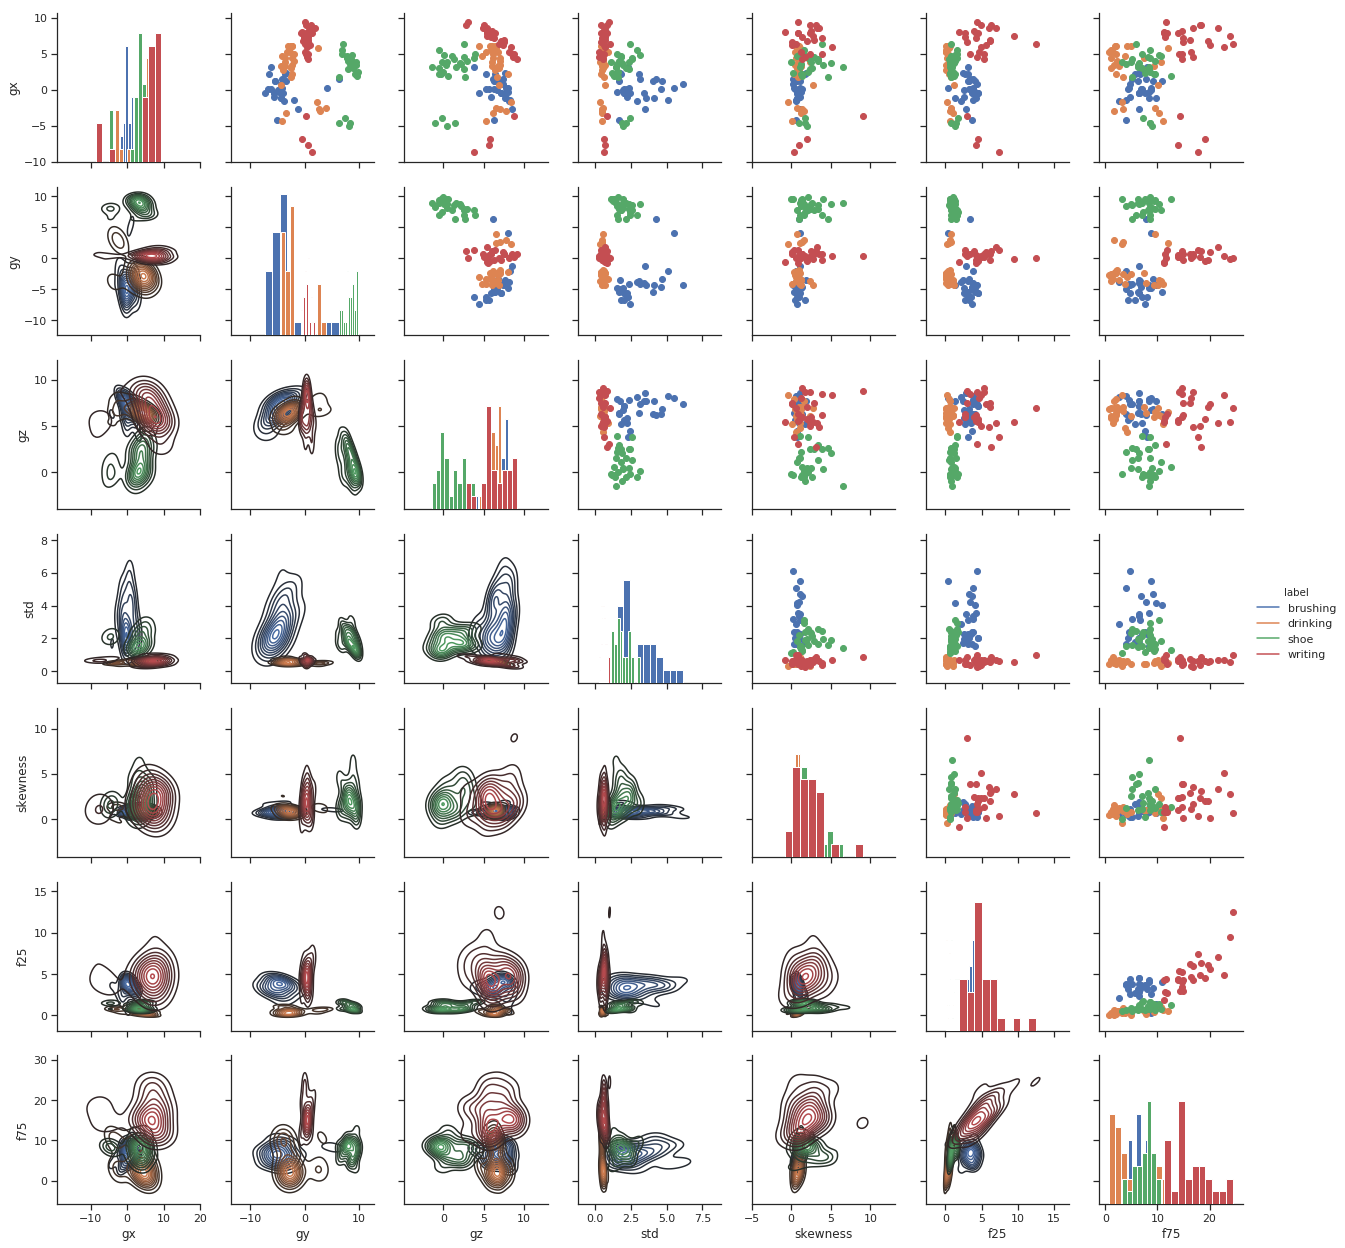

In [17]:
df_2018
g = sns.PairGrid(df_2018.drop("shoe", axis=1), hue="label")
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist)
g = g.add_legend()

In [ ]:
data = sio.loadmat('data2016.mat')
mdata = data["data"]
mdtype = mdata.dtype
print(mdtype.names)
#print(mdata["shoe"][0, 0][0][i][x])

nb_patients = len(mdata["shoe"][0, 0][0])
sequences_len =  len(mdata["shoe"][0, 0][0][0][0])
print(sequences_len)
shoe_x, shoe_y, shoe_z = np.zeros((nb_patients, sequences_len)), np.zeros((nb_patients, sequences_len)), np.zeros((nb_patients, sequences_len))

for i in range(nb_patients):
    tmp = mdata["shoe"][0, 0][0][i]
    shoe_x[i], shoe_y[i], shoe_z[i] = tmp[0][:, 0], tmp[1][:, 0], tmp[2][:, 0]
print(shoe_x)


#ndata = {n: np.array([mdata[n][0, 0][0][k] for k in range(len(mdata[n][0]))]) for n in mdtype.names}  # Extract col names
